In [1]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [4]:
TEXT = open('big.txt').read()
len(TEXT)

6488666

In [5]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [6]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [8]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [9]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


In [10]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [12]:
sample(WORDS)

'turn by it his thought of end later such and'

In [13]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'a': 2, 'is': 2, 'it': 1, 'test': 2, 'this': 1})

In [15]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


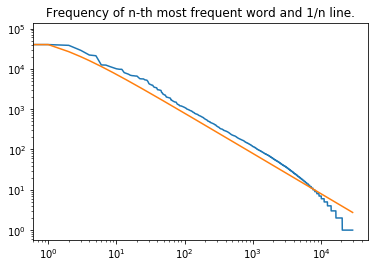

In [16]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [17]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

In [18]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [19]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [20]:
map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?'))

In [22]:
print(list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?'))))

['spelling', 'errors', 'in', 'something', 'whatever', 'unusual', 'mistakes', 'everywhere']


In [23]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [24]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [25]:
correct_text('Speling Errurs IN somethink. Whutever; unuSuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

In [36]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [37]:
for w in tokens('"The" is most common word in English'):
    print(P(w), w)

0.0724066643445 the
0.00884296810325 is
0.000821507574969 most
0.00025966153526 common
0.000269613719538 word
0.0199496057578 in
0.000190900989338 english


In [41]:
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [42]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

2.9833963328e-11 this is a test
8.63747202302e-16 this is a unusual test
0.0 this is a neverbeforeseen test


In [43]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [44]:
max(len(w) for w in COUNTS)

18

In [45]:
def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [47]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [48]:
@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [49]:
segment('choosespain')

['choose', 'spain']

In [50]:
segment('speedofart')

['speed', 'of', 'art']

In [51]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

In [52]:
print(segment(decl))

['when', 'in', 'the', 'course', 'of', 'human', 'events', 'it', 'becomes', 'necessary', 'for', 'one', 'people', 'to', 'dissolve', 'the', 'political', 'bands', 'which', 'have', 'connected', 'them', 'with', 'another', 'and', 'to', 'assume', 'among', 'the', 'powers', 'of', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'natures', 'god', 'entitle', 'them']


In [57]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [58]:
COUNTS1 = load_counts('count_1w.txt')
COUNTS2 = load_counts('count_2w.txt')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

In [59]:
def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # Average the back-off value and zero. //////////////////////////////////////////////////////////////////
        return P1w(word) / 2

In [60]:
print(Pwords(tokens('this is a test')))
print(Pwords2(tokens('this is a test')))
print(Pwords2(tokens('is test a this')))

1.78739820006e-10
6.41367629438e-08
1.18028600367e-11
